In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import seaborn
import shapely
import rioxarray
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
resolution = 8
horizontal_crs = 2193

### Load in GeoFabrics Bathymetry estimates

In [3]:
cache_path = pathlib.Path(r"C:\Local\data\catchments\Westport\caches\NZ20_Westport")
folder = "paper"
characteristics = {}
characteristics["1"] = geopandas.read_file(cache_path / "test" / "1" / "river_characteristics.geojson")
characteristics["2"] = geopandas.read_file(cache_path / "test" / "2" / "river_characteristics.geojson")
characteristics["3"] = geopandas.read_file(cache_path / "test" / "3" / "river_characteristics.geojson")
characteristics["4"] = geopandas.read_file(cache_path / "test" / "4" / "river_characteristics.geojson")
characteristics["5"] = geopandas.read_file(cache_path / "test" / "5" / "river_characteristics.geojson")


## Plot different attributes


In [8]:
characteristics["1"].columns

Index(['min_z_centre', 'min_z_centre_unimodal', 'min_z_water', 'slope',
       'min_z_centre_unimodal_mean_0.05km', 'slope_mean_0.05km',
       'min_z_centre_unimodal_mean_0.25km', 'slope_mean_0.25km',
       'min_z_centre_unimodal_mean_0.5km', 'slope_mean_0.5km',
       'min_z_centre_unimodal_mean_1.0km', 'slope_mean_1.0km', 'widths',
       'first_bank_i', 'last_bank_i', 'threshold', 'channel_count',
       'flat_widths', 'first_flat_bank_i', 'last_flat_bank_i', 'valid',
       'valid_widths', 'valid_flat_widths', 'valid_threhold',
       'widths_mean_0.05km', 'flat_widths_mean_0.05km',
       'thresholds_mean_0.05km', 'widths_mean_0.15km',
       'flat_widths_mean_0.15km', 'thresholds_mean_0.15km',
       'widths_mean_0.2km', 'flat_widths_mean_0.2km', 'thresholds_mean_0.2km',
       'widths_mean_0.25km', 'flat_widths_mean_0.25km',
       'thresholds_mean_0.25km', 'geometry'],
      dtype='object')

In [9]:
characteristics["1"][["threshold", "thresholds_mean_0.05km"]].head(1)

,threshold,thresholds_mean_0.05km
0,1.824523,1.957248


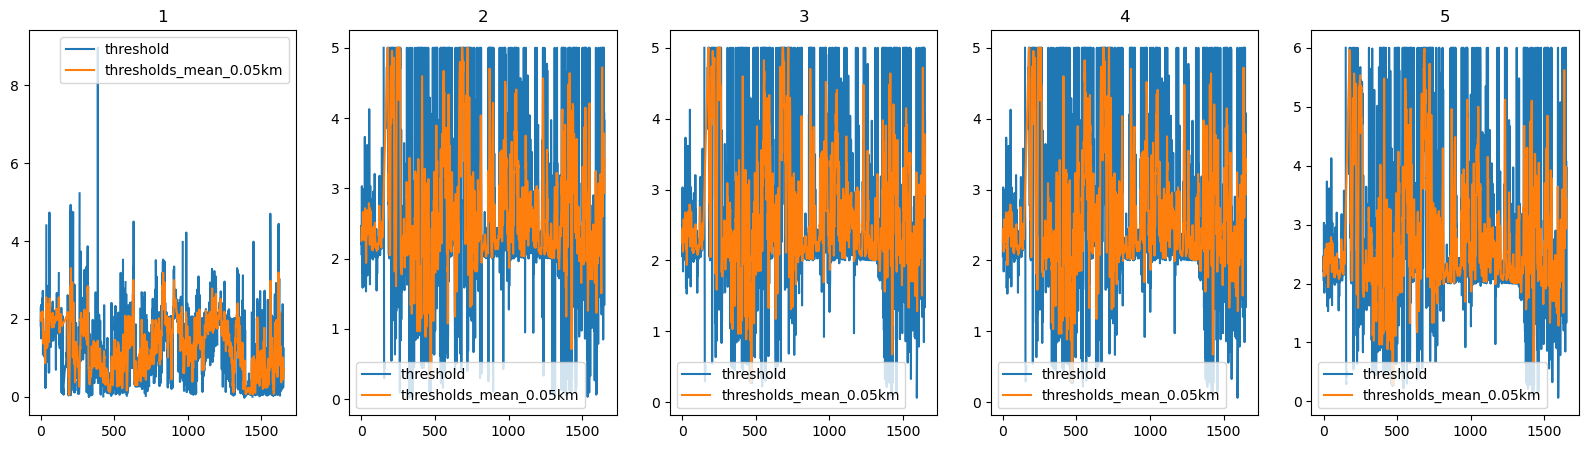

In [16]:
import matplotlib.pyplot
fig, axs = matplotlib.pyplot.subplots(ncols=5, nrows=1, figsize=(20, 5))
for i, key in enumerate(characteristics):
    characteristics[key][["threshold", "thresholds_mean_0.05km"]].plot(ax=axs[i], title=key)
#polygon.plot(ax=ax, color='g')
#measured_lines.plot(ax=ax)

## Sample DEM for elevations
Record the Bias and STDev for each cross section against the two DEMS

<Axes: >

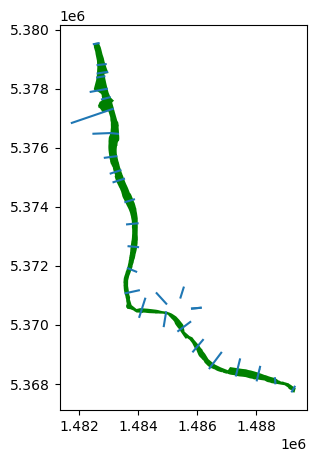

In [9]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 5))
polygon.plot(ax=ax, color='g')
measured_lines.plot(ax=ax)

# Sample every 1m
Use Linear interpolation in between

In [10]:
comparisons_sampled = {**dict((f"{key} z", []) for key in dems), 
                       **{"Measured Section z": [], "Section": [], "River": [], "Distance Upstream [m]": [], "Offset [m]": []}}
for index, row in measured_lines.iterrows():
    print(f"Section number = {index}")
    line = row.geometry
    distance_upstream = float(river_centreline.project(measured_centres.iloc[index].geometry))
    for offset in list(range(int(numpy.ceil(line.length)))):
        point = line.interpolate(offset)
        for key in dems:
            comparisons_sampled[f"{key} z"].append(float(dems[key].z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Measured Section z"].append(point.z)
        comparisons_sampled["Section"].append(row['Section'])
        comparisons_sampled["River"].append(polygon.iloc[0].geometry.contains(point))
        comparisons_sampled["Distance Upstream [m]"].append(distance_upstream)
        comparisons_sampled["Offset [m]"].append(offset)
        
comparisons_sampled = pandas.DataFrame.from_dict(comparisons_sampled)

Section number = 0
Section number = 1
Section number = 2
Section number = 3
Section number = 4
Section number = 5
Section number = 6
Section number = 7
Section number = 8
Section number = 9
Section number = 10
Section number = 11
Section number = 12
Section number = 13
Section number = 14
Section number = 15
Section number = 16
Section number = 17
Section number = 18
Section number = 19
Section number = 20
Section number = 21
Section number = 22
Section number = 23
Section number = 24
Section number = 25
Section number = 26
Section number = 27
Section number = 28


# Plot sampled elevations along entire sections
Plot the sampled elevations along individual cross-sections including the on-land portions as a sanity check.

In [11]:
columns = ["Measured Section z"]; columns.extend([f"{key} z" for key in dems])
for section in ordered_measured_sections:
    figure = comparisons_sampled[comparisons_sampled["Section"]==section][columns].plot(title=section)
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / f"{section}.png")
    matplotlib.pyplot.close()
    
    distance = comparisons_sampled[comparisons_sampled['Section']==section]['Distance Upstream [m]'].iloc[0]
    figure = comparisons_sampled[comparisons_sampled["Section"]==section][columns].plot(title=f"{distance}m distance upstream")
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / "distance_upstream" / f"{distance}m_upstream.png")
    matplotlib.pyplot.close()

In [12]:
columns = ["Measured Section z"]; columns.extend([f"{key} z" for key in dems])
for section in ordered_measured_sections:
    figure = comparisons_sampled[(comparisons_sampled["Section"]==section) & (comparisons_sampled["River"]==True)][columns].plot(title=section);
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / f"only_river_{section}.png")
    matplotlib.pyplot.close()
    
    distance = comparisons_sampled[comparisons_sampled['Section']==section]['Distance Upstream [m]'].iloc[0]
    figure = comparisons_sampled[(comparisons_sampled["Section"]==section) & (comparisons_sampled["River"]==True)][columns].plot(title=f"{distance}m distance upstream")
    figure.figure.savefig(cache_path / folder / "measured_section_comparison" / "distance_upstream" / f"only_river_{distance}m_upstream.png")
    matplotlib.pyplot.close()

## Plot elevation errors along each section
95% confidence interval plot for the errors along each section in the river. 

In [13]:
for key in dems:
    comparisons_sampled[f"{key} Elevation Errors"] = comparisons_sampled[f"{key} z"] - comparisons_sampled["Measured Section z"]

In [14]:
comparisons_sampled.head(1)

,Unconditioned z,Wide Rupp z,Wide Neal z,Test Rupp 3 z,Test Rupp 4 z,Test Rupp 5 z,Interpolated Sections z,Measured Section z,Section,River,Distance Upstream [m],Offset [m],Unconditioned Elevation Errors,Wide Rupp Elevation Errors,Wide Neal Elevation Errors,Test Rupp 3 Elevation Errors,Test Rupp 4 Elevation Errors,Test Rupp 5 Elevation Errors,Interpolated Sections Elevation Errors
0,-0.695949,-3.873493,-4.409975,-0.454296,-0.454296,-0.454296,-0.567853,0.117,Section1,False,28.377383,0,-0.812949,-3.990493,-4.526975,-0.571296,-0.571296,-0.571296,-0.684853


In [15]:
comparisons_for_plotting=comparisons_sampled.drop(
    columns=[f"{key} z" for key in dems]).drop(columns=["Measured Section z"]).rename(
    columns=dict((f"{key} Elevation Errors", f"{key}") for key in dems)).melt(
    id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]")

In [16]:
comparisons_for_plotting.to_json(cache_path / folder / "measured_section_comparison" / "compairson_for_plotting.json")

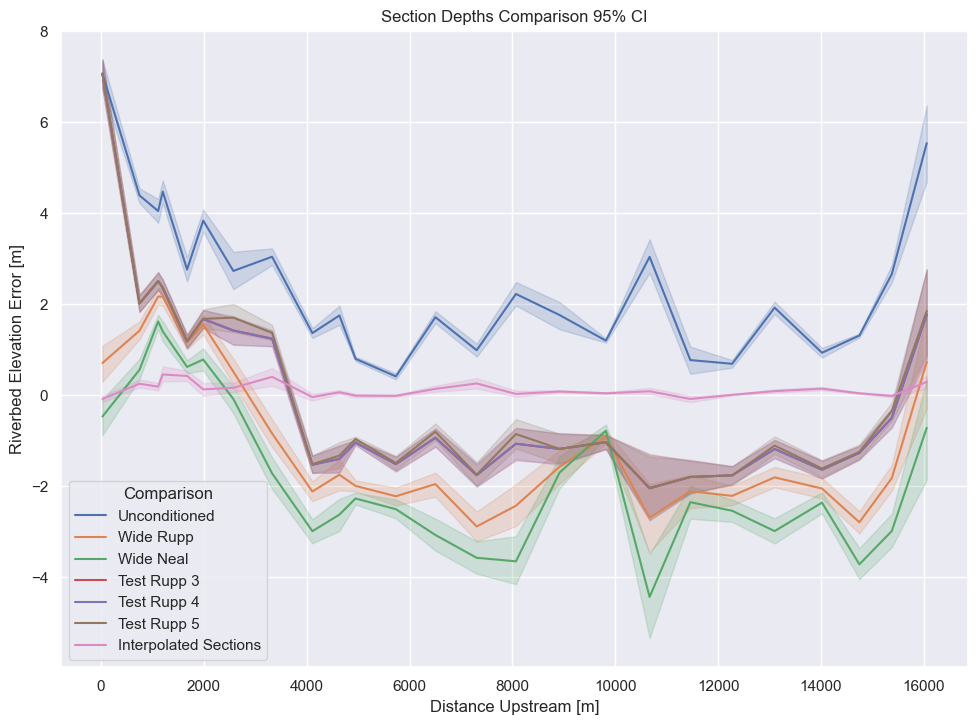

In [17]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=comparisons_for_plotting[comparisons_for_plotting["River"]], x="Distance Upstream [m]", y="Riverbed Elevation Error [m]", hue="Comparison")
figure.set(title='Section Depths Comparison 95% CI')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_depth_errors.png") 

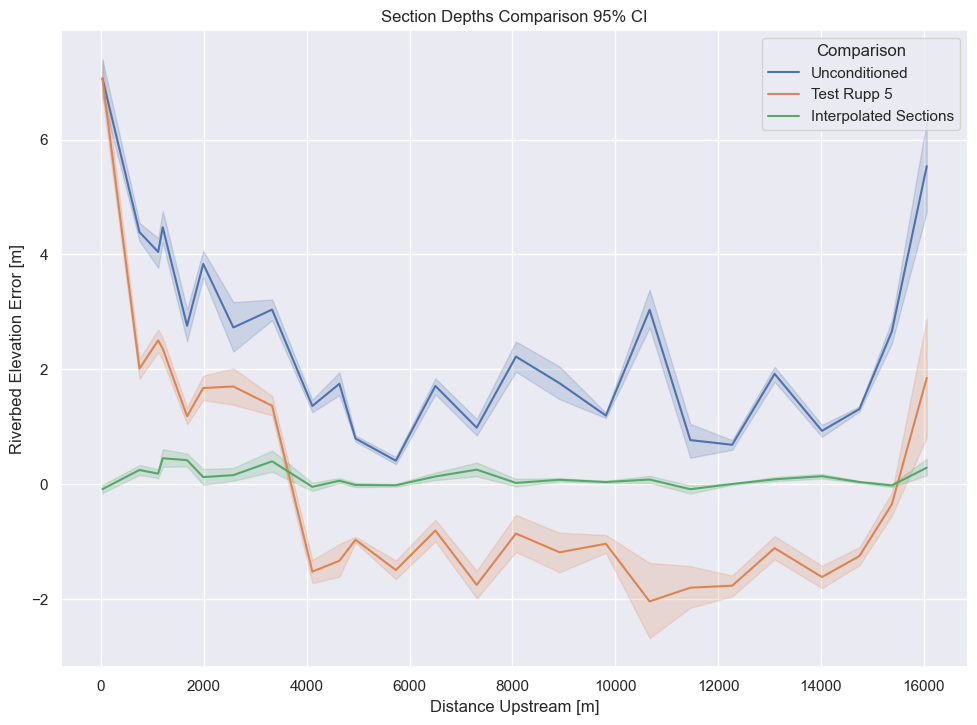

In [18]:
data = comparisons_for_plotting[(comparisons_for_plotting['Comparison'] == 'Unconditioned')
                                | (comparisons_for_plotting['Comparison'] == 'Interpolated Sections')
                                | (comparisons_for_plotting['Comparison'] == 'Measured Section')  
                                | (comparisons_for_plotting['Comparison'] == 'Test Rupp 5')]
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=data[data["River"]], x="Distance Upstream [m]", y="Riverbed Elevation Error [m]", hue="Comparison")
figure.set(title='Section Depths Comparison 95% CI')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_depth_errors.png") 

In [19]:
summary = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=[f"{key} z" for key in dems]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
depth_summary = pandas.DataFrame([[summary.mean()[f"{key} Elevation Errors"] for key in dems],
                                  [summary.std()[f"{key} Elevation Errors"] for key in dems]],
                                  index = ["Mean Error", "Standard Deviation"], columns=[key for key in dems])
depth_summary

,Unconditioned,Wide Rupp,Wide Neal,Test Rupp 3,Test Rupp 4,Test Rupp 5,Interpolated Sections
Mean Error,2.485267,-0.667128,-1.375458,0.19081,0.190735,0.246310,0.140129
Standard Deviation,2.594352,2.872629,3.105950,2.83990,2.839958,2.838411,0.834273


# Channel Area error
The total area of the channel at each section

In [20]:
channel_depths = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=[f"{key} Elevation Errors" for key in dems]).drop(columns=["River", "Section"]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
section_max_evaluation = channel_depths.groupby("Distance Upstream [m]")[["Measured Section z"]].max()

In [21]:
channel_depths.head(1)

,,Unconditioned z,Wide Rupp z,Wide Neal z,Test Rupp 3 z,Test Rupp 4 z,Test Rupp 5 z,Interpolated Sections z,Measured Section z
Distance Upstream [m],Offset [m],,,,,,,,
28.377383,35,-1.198688,-5.176809,-5.945302,-1.167335,-1.167335,-1.167335,-2.054041,-2.396877


In [22]:
# Some hacky code to subtract the max elevation from each column in turn
channel_depths["Measured Section"] = section_max_evaluation - channel_depths[["Measured Section z"]]
for key in dems:
    channel_depths[key] = section_max_evaluation.rename(columns={"Measured Section z": f"{key} z"}) - channel_depths[[f"{key} z"]]
channel_depths.head(1)

,,Unconditioned z,Wide Rupp z,Wide Neal z,Test Rupp 3 z,Test Rupp 4 z,Test Rupp 5 z,Interpolated Sections z,Measured Section z,Measured Section,Unconditioned,Wide Rupp,Wide Neal,Test Rupp 3,Test Rupp 4,Test Rupp 5,Interpolated Sections
Distance Upstream [m],Offset [m],,,,,,,,,,,,,,,,
28.377383,35,-1.198688,-5.176809,-5.945302,-1.167335,-1.167335,-1.167335,-2.054041,-2.396877,5.557463,4.359273,8.337394,9.105888,4.32792,4.32792,4.32792,5.214626


In [23]:
channel_area = channel_depths.drop(
    columns=["Measured Section z"]).drop(
    columns=[f"{key} z" for key in dems]).groupby("Distance Upstream [m]").sum()
channel_area.head(1)

,Measured Section,Unconditioned,Wide Rupp,Wide Neal,Test Rupp 3,Test Rupp 4,Test Rupp 5,Interpolated Sections
Distance Upstream [m],,,,,,,,
28.377383,1984.546642,748.214863,1861.296577,2067.188879,747.944373,747.944373,747.944373,1999.486238


In [24]:
areas_for_plotting=channel_area.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

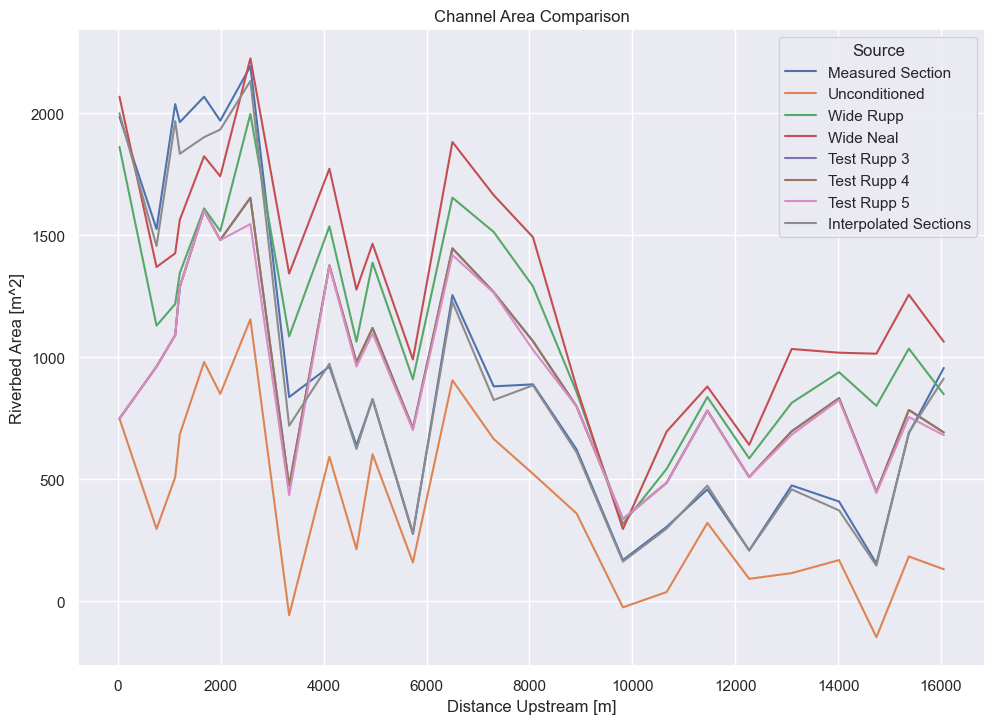

In [25]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=areas_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source")
figure.set(title='Channel Area Comparison')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_area_errors.png") 

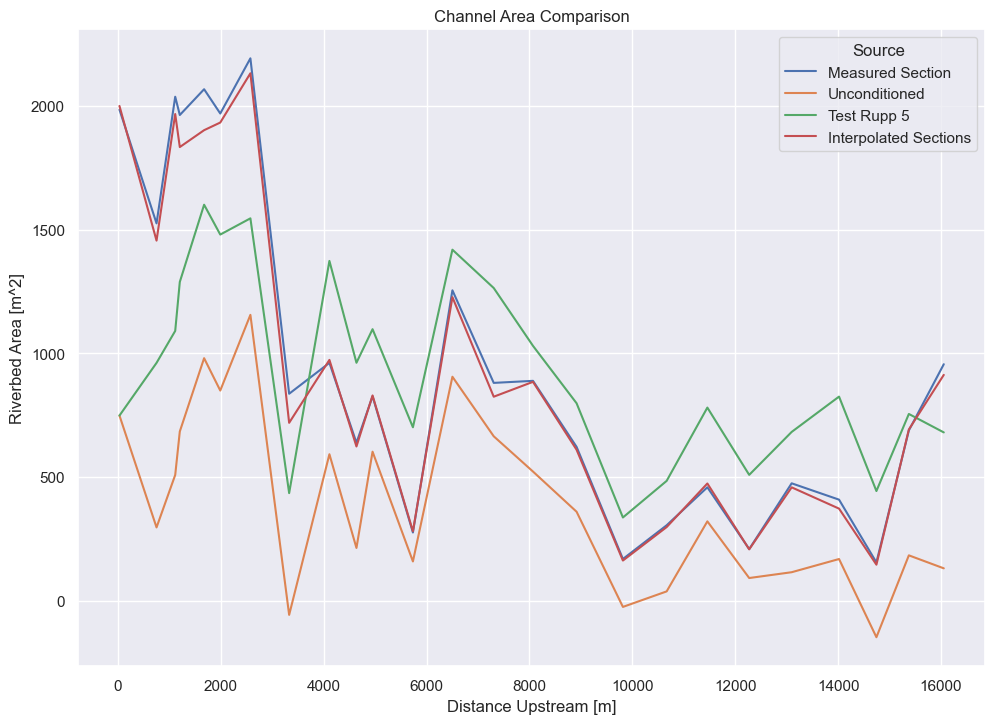

In [26]:
data = areas_for_plotting[(areas_for_plotting['Source'] == 'Unconditioned') 
                        | (areas_for_plotting['Source'] == 'Measured Section')
                        | (areas_for_plotting['Source'] == 'Interpolated Sections') 
                        | (areas_for_plotting['Source'] == 'Test Rupp 5')]
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
figure = seaborn.lineplot(data=data, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source")
figure.set(title='Channel Area Comparison')
figure.get_figure().savefig(cache_path / folder / "measured_section_comparison" / "section_area_errors.png") 

# Exploring potential sources of error
## 1. Using measured versus estimate flow
The flow guage stations provide measured mean-annual flood flows. These can be used instead of the estimated ones across NZ. We can look at the impact of the different values by simply scaling the depths and then rerunning the generate hydrologically conditioned DEM steps.

#### Measured flow guage data
* [Te Kuha](https://www.lawa.org.nz/explore-data/west-coast-region/water-quantity/monitoring-sites/buller-rv-te-kuha/) - 3727.09 m³/s

#### Estimated flow data
* Te Kuha section NZREACH ID 12012463 - 4225.07 m³/s

#### Scaling to the different depths
In both cases the equation can be re-arragned to: h=(n/wS^b)^1/(1+a)*Q^1/(1+a) where 1/(1+a) differs in each case.
So depth can be scaled by (Qmeasured/Qold) ^ 1/(1+a). Where Qmeasured/Qold = 0.8821368640046201.
This means in each case:
* Uniform flow - 1/(1+a) = 0.6 -> x 0.9275163689031669
* Conceptual multivariate regression - 1/(1+a) = 0.573 -> x 0.9306622787286434
So depth can be scaled by (Qmeasured/Qold) ^ 1/(1+a)

## 2. Different thresholds
##### Currently
* narrow is 0.5 min to 0.75 max
* wide is 2 min to 5 max
Looking through the sampled sections it looks like the banks are higher than  5m generally (at least for bank full flow), and the water section could be less than 2m - try say 1m min, 10 max

## 3. Turn off the depth adjustment
#### Currently 
* My code for adjusting the depth estimate based on the banks doesn't seem to be quite right!
* It also makes the rivers deeper which is not desired based on a comparison to the sections
#### Future
Drope out this 'correction' as an unneeded complexity at this stage. 

## 4. Could add a proportion flowing through sediment
In braided rivers most or even all flow can be through the river gravels. 

#### Future
1. Could add a user specified 'proportion of flow in sediments' 
2. May just want to keep at it is as trying to make a 'hydrologically conditioned DEM' as opposed to the actual measured cross sections.

Questions: are their models where would want the actual bed elevation as they model the flow through the gravels - I think so - sediment transport models

# Explore depths

In [74]:
river_depths = geopandas.read_file(cache_path / folder / "wide_river" / "river_bathymetry.geojson")
river_depths_all = geopandas.read_file(cache_path / folder / "wide_river" / "river_characteristics.geojson")

In [75]:
river_depths_all.columns

Index(['min_z_centre', 'min_z_centre_unimodal', 'min_z_water', 'slope',
       'min_z_centre_unimodal_mean_0.05km', 'slope_mean_0.05km',
       'min_z_centre_unimodal_mean_0.25km', 'slope_mean_0.25km',
       'min_z_centre_unimodal_mean_0.5km', 'slope_mean_0.5km',
       'min_z_centre_unimodal_mean_1.0km', 'slope_mean_1.0km', 'widths',
       'threshold', 'channel_count', 'flat_widths', 'valid', 'valid_widths',
       'valid_flat_widths', 'valid_threhold', 'widths_mean_0.05km',
       'flat_widths_mean_0.05km', 'thresholds_mean_0.05km',
       'widths_mean_0.15km', 'flat_widths_mean_0.15km',
       'thresholds_mean_0.15km', 'widths_mean_0.2km', 'flat_widths_mean_0.2km',
       'thresholds_mean_0.2km', 'widths_mean_0.25km',
       'flat_widths_mean_0.25km', 'thresholds_mean_0.25km', 'geometry'],
      dtype='object')

In [98]:
river_depths.head(0)

,bed_elevation_Neal_et_al,bed_elevation_Rupp_and_Smart,bank_height,width,flat_widths_mean_0.05km,depth_Neal_et_al,depth_Rupp_and_Smart,flood_depth_Neal_et_al,flood_depth_Rupp_and_Smart,geometry


<Axes: >

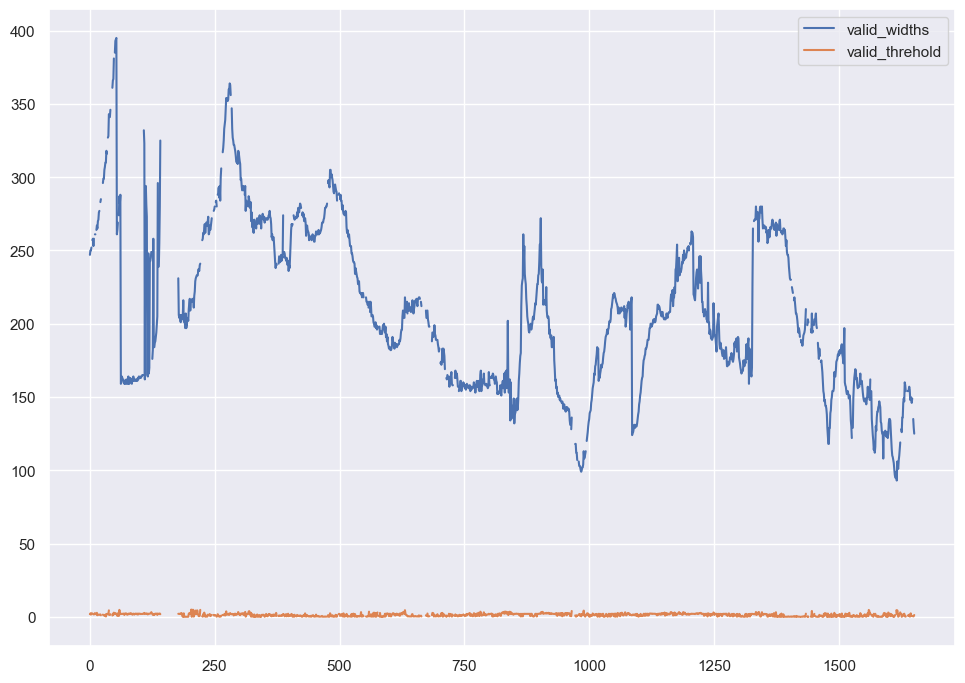

In [99]:
river_depths_all[["valid", "valid_widths", "valid_threhold"]].plot()

<Axes: >

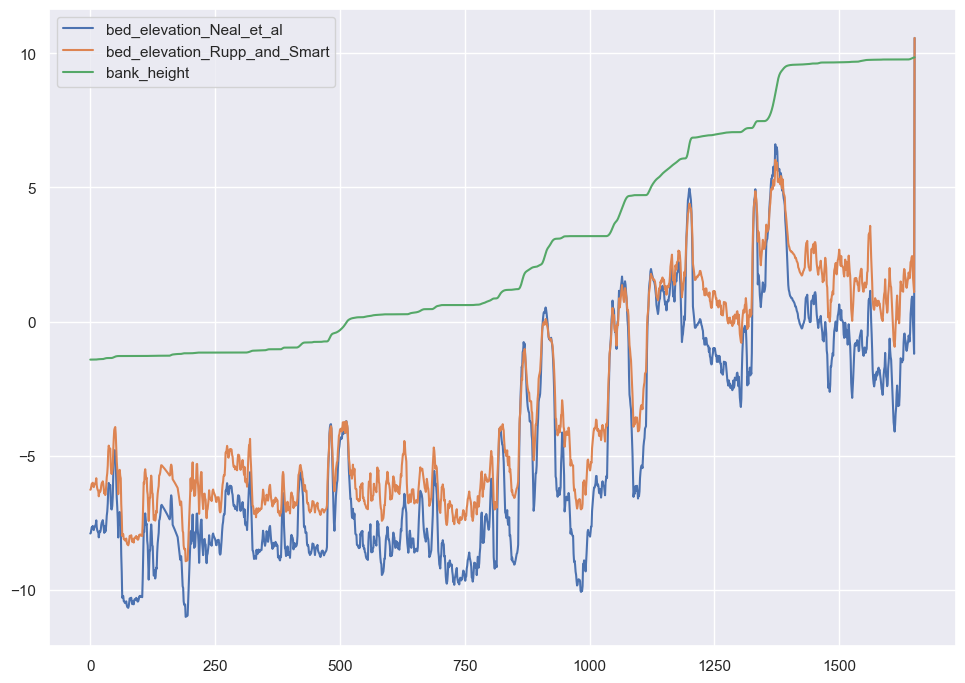

In [69]:
river_depths[["bed_elevation_Neal_et_al", "bed_elevation_Rupp_and_Smart", "bank_height"]].plot()

<Axes: >

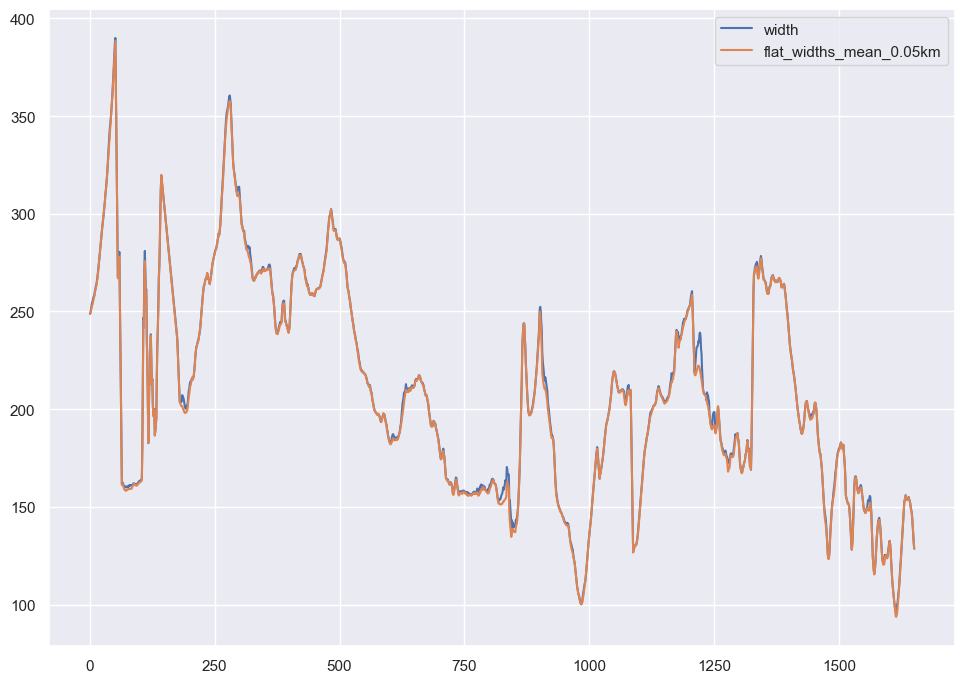

In [72]:
river_depths[["width", "flat_widths_mean_0.05km"]].plot()

<Axes: >

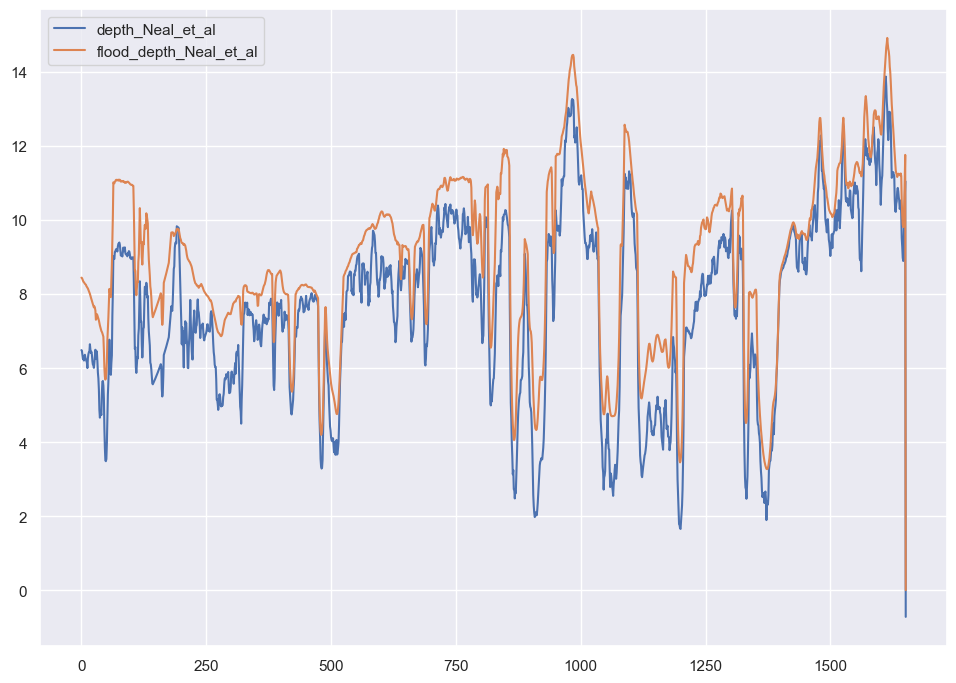

In [73]:
river_depths[["depth_Neal_et_al", "flood_depth_Neal_et_al"]].plot()

<Axes: >

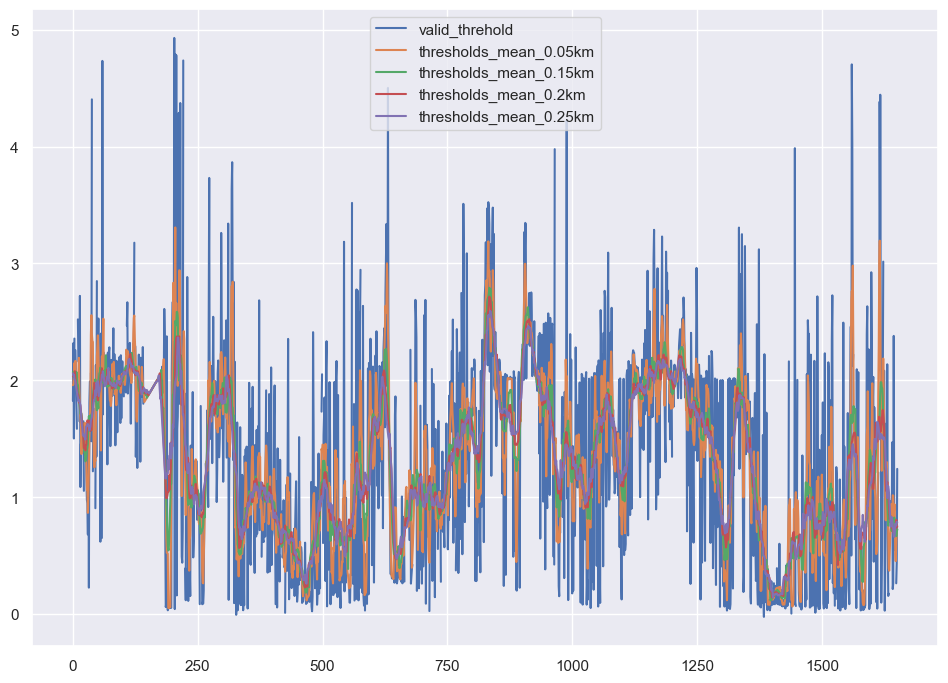

In [101]:
river_depths_all[["valid_threhold", "thresholds_mean_0.05km", "thresholds_mean_0.15km", "thresholds_mean_0.2km", "thresholds_mean_0.25km"]].plot() # "threshold", 

<Axes: >

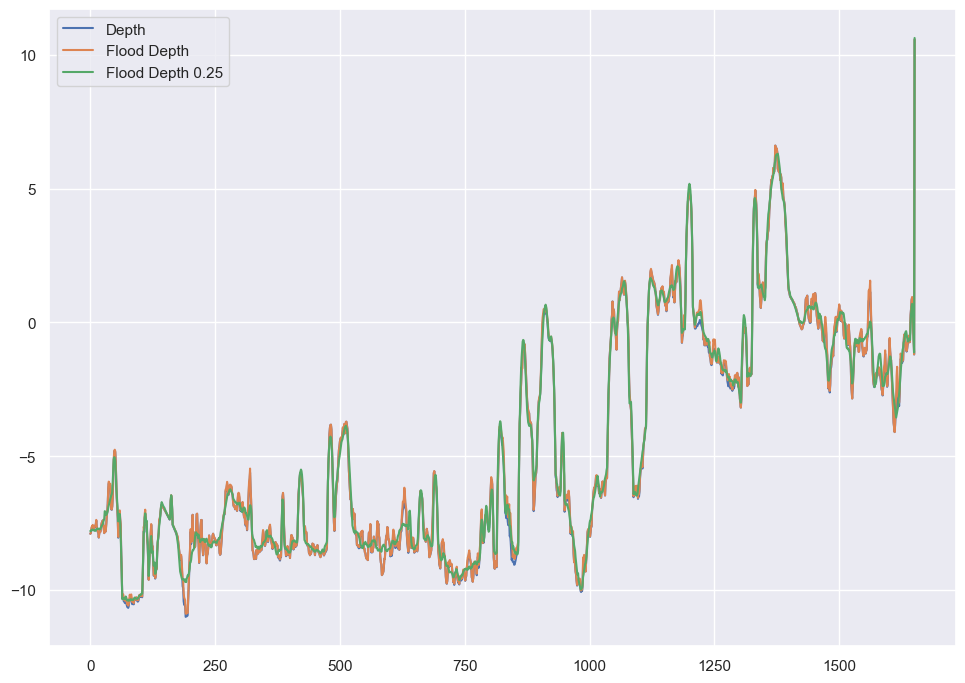

In [95]:
pandas.concat({"Depth":(river_depths_all["min_z_centre_unimodal"] - river_depths["depth_Neal_et_al"]),
               "Flood Depth": (river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.05km"]),
               "Flood Depth 0.25": (river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.25km"])},axis=1).plot()

<Axes: >

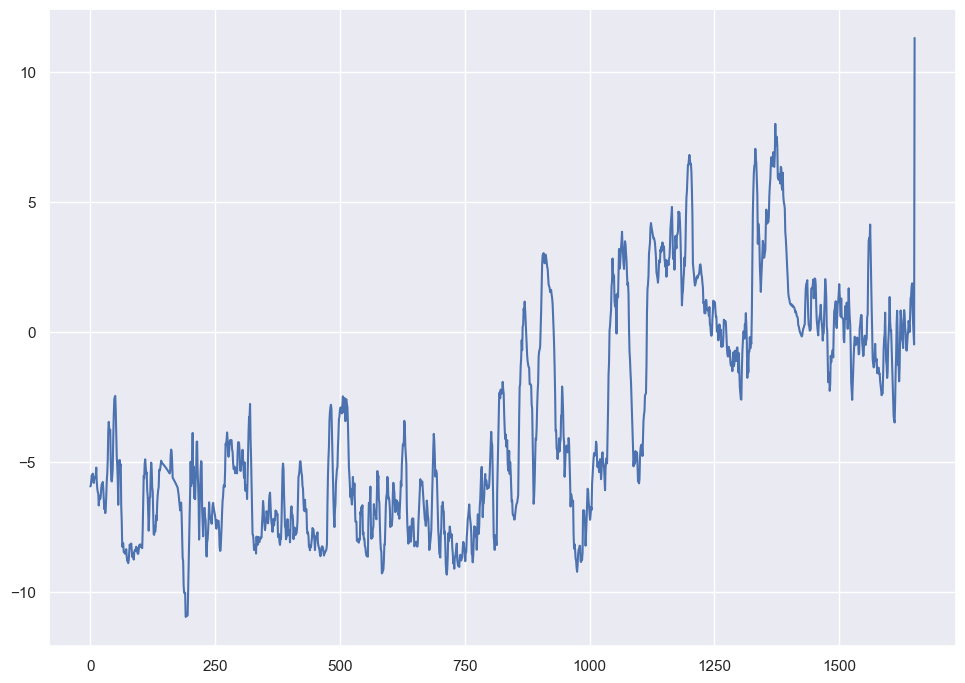

In [80]:
(river_depths_all["min_z_centre_unimodal"] - river_depths["depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.05km"]).plot()

<Axes: >

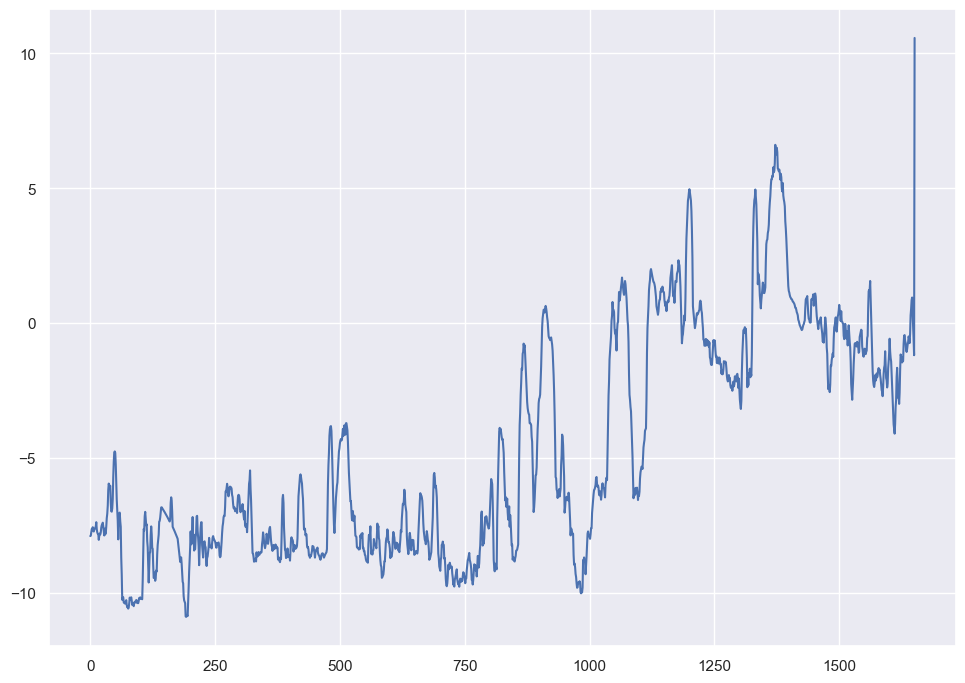

In [82]:
(river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["thresholds_mean_0.05km"]).plot()

<Axes: >

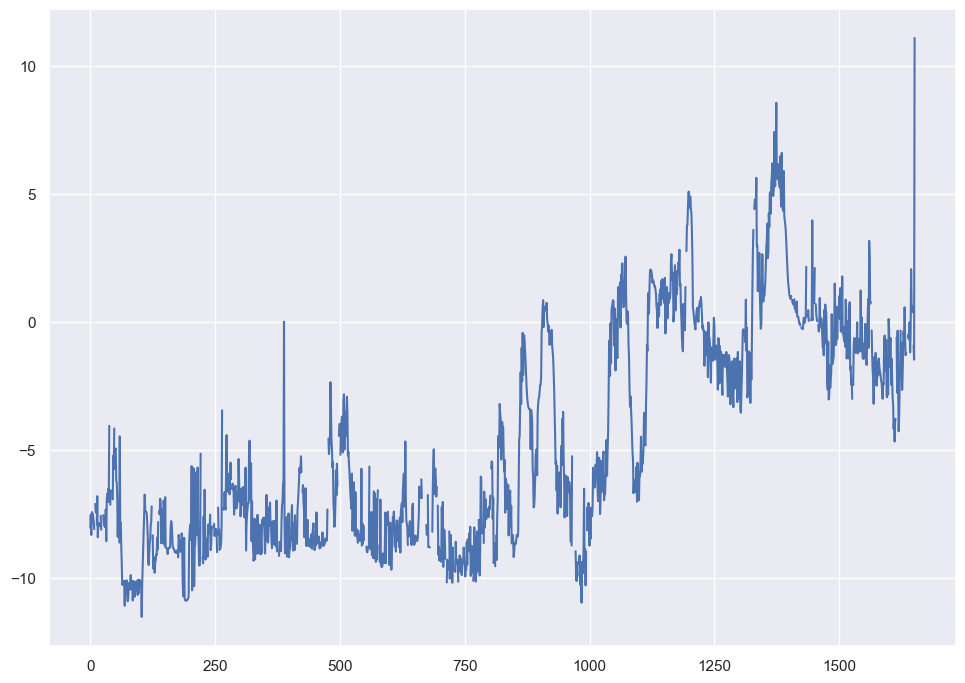

In [83]:
(river_depths_all["min_z_centre_unimodal"] - river_depths["flood_depth_Neal_et_al"] + river_depths_all["threshold"]).plot()